In [1]:
import sys
from pathlib import Path
# Set path for external modules
code_dir = Path("../utils").resolve()
if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))

import numpy as np

import galsim

import ngmix

import matplotlib.pyplot as plt

from make_data import *
from noise_utils import *
from shear_meas import *

# Tutorial Metacalibration

When we try to extract shear from galaxy shapes we have to calibrate for biases coming from several sources:
- galaxy model
- noise
- selection effects
- detection

Before, we used simulations to calibrate those biases but **Metacalibration** propose a fully data driven approach to calibrate them.  
We can defined the measured galaxy ellipticities $e^{\rm{obs}}$ as:
```math
e^{\rm{obs}} = (1+m)\gamma + c
```
where $\gamma$ is the shear, $c$ additive biases and $m$ the multiplicative biases we are interested in.  
Measuring the multiplicative biases is equivalent to measuring the response, $R$, of our estimator to an applied shear. We can write this as:
```math
(1+m) = R = \frac{\partial e}{\partial \gamma}
```
This is the principle behind **Metacalibration** see [Huff & Mandelbaum (2017)](https://arxiv.org/abs/1702.02600) and [Sheldon & Huff (2017)](https://arxiv.org/abs/1702.02601).

## Metacalibration in practice

We will use finite differencies to estimate the response $R$:
```math
R = \frac{\partial e}{\partial \gamma} \approx \frac{e_{i}^{+} - e_{i}^{-}}{\Delta \gamma_{i}}
```
with $e_{i}^{+}$ the ellipticity measured on an image with $+\gamma_{i}$ applied and similarly $e_{i}^{-}$ with $-\gamma_{i}$. Now we will see how to applied an articial shear in practice.

We want to apply a shear to the galaxy and to the galaxy **only**. That means we need to deconvolve the galaxy from the PSF first then apply a shear and reconvolve by a PSF. The re-convolved PSF has to be slightly larger than the original one to smooth out the amplified noise due to the deconvolution (we'll talk more about the noise later). Appart from being larger, the reconvolve can be anything, so we can choose a profile that simplify the shape measurement such as an isotropic Gaussian.

![_](notebook_data/metacal_workflow.png)

#### Step 1: Deconvolution
In ngmix: [_set_data](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/metacal/metacal.py#L386)

In [2]:
pixel_scale = 0.2
psf_model = "gauss"
psf_fwhm = 0.6
gal, psf, _ = make_data_metacal_simple(
    pixel_scale=pixel_scale,
    psf_model=psf_model,
    psf_fwhm=psf_fwhm,
    do_shift=False,
)

In [3]:
# Interpolate the galaxy image and the PSF
gal_interp = galsim.InterpolatedImage(galsim.Image(gal, scale=pixel_scale))
psf_interp = galsim.InterpolatedImage(galsim.Image(psf, scale=pixel_scale))

In [4]:
# Deconvolve the galaxy image from the PSF
psf_deconv = galsim.Deconvolve(psf_interp)
gal_deconv = galsim.Convolve(gal_interp, psf_deconv)

In [5]:
# Get pixelization
pixel = galsim.Pixel(pixel_scale)

#### Step 2: Apply shear
In ngmix: [get_sheared_image_nopsf](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/metacal/metacal.py#L368)

In [6]:
shear = galsim.Shear(g1=0.01, g2=0.0)
gal_shear = gal_deconv.shear(shear)

#### Step 3: Reconvolve
In ngmix: [_get_target_gal_obj](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/metacal/metacal.py#L356)

In [7]:
# New PSF
psf_reconv = galsim.Gaussian(fwhm=psf_fwhm)

# Dilate the PSF
g = np.sqrt(shear.g1**2 + shear.g2**2)
dilation = 1.0 + 2.0*g
psf_reconv = psf_reconv.dilate(dilation)

# Convolve the new PSF with the pixelization
psf_reconv_pixel = galsim.Convolve(psf_reconv, pixel)

gal_new = galsim.Convolve(gal_shear, psf_reconv_pixel)


psf_mcal = psf_reconv_pixel.drawImage(
    nx=psf.shape[1],
    ny=psf.shape[0],
    scale=pixel_scale,
    method='no_pixel',
).array

#### Step 4: Draw the new object
In ngmix: [get_target_image](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/metacal/metacal.py#L320)

In [8]:
# Draw the object in 'no_pixel' mode as it would be included in the PSF already
gal_mcal = gal_new.drawImage(
    nx=gal.shape[1],
    ny=gal.shape[0],
    scale=pixel_scale,
    method='no_pixel',
).array

Text(0.5, 1.0, 'img_sheared')

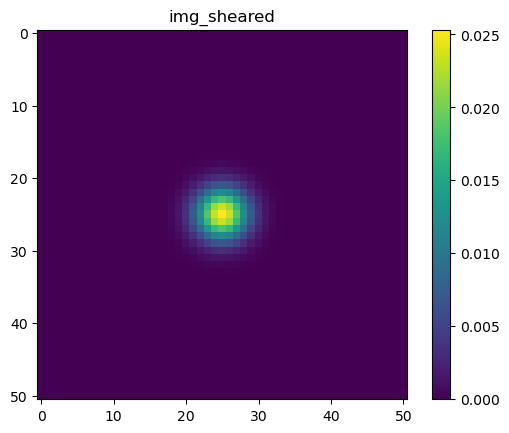

In [9]:
plt.imshow(gal_mcal)
plt.colorbar()
plt.title("img_sheared")

In [10]:
meas_shape = galsim.hsm.EstimateShear(galsim.Image(gal_mcal, scale=pixel_scale), galsim.Image(psf_mcal, scale=pixel_scale))
s = galsim.Shear(e1=meas_shape.corrected_e1, e2=meas_shape.corrected_e2)
print("We check that we recover the shear we have applied:")
print(f"Input shear:\ng1={s.g1}    target: 0.01\ng2={s.g2}  target: 0.0")

We check that we recover the shear we have applied:
Input shear:
g1=0.009756677024762479    target: 0.01
g2=4.9793677427602535e-05  target: 0.0


### We can check the applied shear by making a "perfect" metacalibrated image

In [11]:
gal_mcal_perf, psf_mcal_perf, _ = make_data_metacal_simple(
    g1=0.01,
    g2=0.0,
    psf_model="gauss",
    psf_fwhm=psf_fwhm*dilation,
    do_shift=False,
)

Text(0.5, 1.0, 'img_sheared - img_perfect')

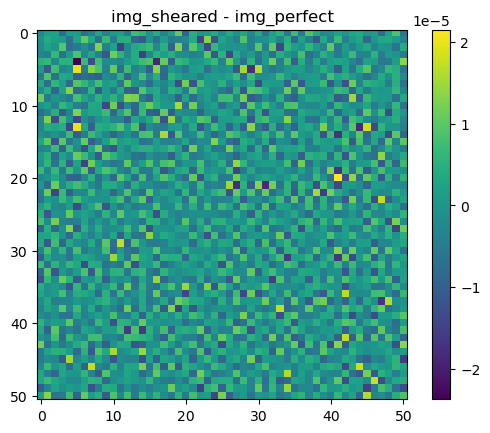

In [12]:
plt.imshow(gal_mcal - gal_mcal_perf)
plt.colorbar()
plt.title("img_sheared - img_perfect")

## Now we can do it automatically with ngmix

In [13]:
pixel_scale = 0.2
noise_sigma = 1e-5
gal, psf, _ = make_data_metacal_simple(
    psf_model=psf_model,
    psf_fwhm=psf_fwhm,
    noise_sigma=noise_sigma,
    pixel_scale=pixel_scale,
    do_shift=False,
)

ngmix works with [**Observation**](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/observation.py#L66)

In [14]:
img_shape = gal.shape
psf_shape = psf.shape

img_center = ((img_shape[1]-1)/2., (img_shape[0]-1)/2.)
psf_center = ((psf_shape[1]-1)/2., (psf_shape[0]-1)/2.)

# Ngmix handles the WCS with a Jacobian transformation
img_jacob = ngmix.DiagonalJacobian(
    row=img_center[1],
    col=img_center[0],
    scale=pixel_scale,
)
psf_jacob = ngmix.DiagonalJacobian(
    row=psf_center[1],
    col=psf_center[0],
    scale=pixel_scale,
)

# We first create a PSF observation
psf_obs = ngmix.Observation(
    image=psf,
    jacobian=psf_jacob,
)

# Then we create the object observation and we pass the PSF observation
obs = ngmix.Observation(
    image=gal,
    weight=np.ones(img_shape) * 1/noise_sigma**2,  # Weights are inverse variance
    jacobian=img_jacob,
    psf=psf_obs,
)

Now we can create the metacalibrated images  
Ngmix: [get_all_metacal](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/metacal/convenience.py#L16)

In [15]:
rng = np.random.RandomState(42)

obs_mcal = ngmix.metacal.get_all_metacal(
    obs,
    psf="fitgauss",
    step=0.01,
    fixnoise=True, # We will see justr after the effect of this
    types=["noshear", "1p"],
    rng=rng,
)

Text(0.5, 1.0, '1p - noshear')

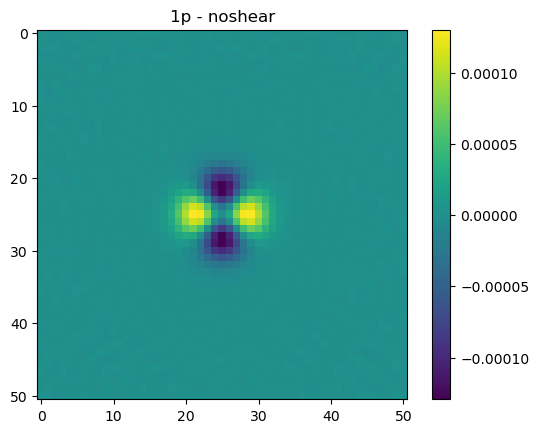

In [16]:
plt.imshow(obs_mcal["1p"].image - obs_mcal["noshear"].image)
plt.colorbar()
plt.title("1p - noshear")

In [17]:
meas_shape = galsim.hsm.EstimateShear(galsim.Image(obs_mcal["1p"].image, scale=pixel_scale), galsim.Image(obs_mcal["1p"].psf.image, scale=pixel_scale))
s = galsim.Shear(e1=meas_shape.corrected_e1, e2=meas_shape.corrected_e2)
print("We check that we recover the shear we have applied:")
print(f"Input shear:\ng1={s.g1}  target: 0.01\ng2={s.g2}  target: 0.0")

We check that we recover the shear we have applied:
Input shear:
g1=0.009514593384166202  target: 0.01
g2=9.39761394665894e-05  target: 0.0


We can compare the image mage through ngmix to the "perfect" sheared image

Text(0.5, 1.0, '1p_ngmix - 1p_perfect')

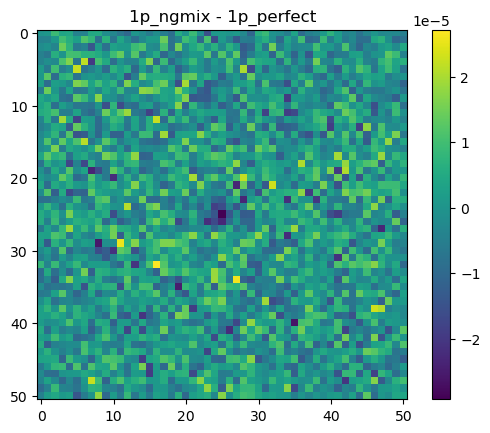

In [18]:
plt.imshow(obs_mcal["1p"].image - gal_mcal_perf)
plt.colorbar()
plt.title("1p_ngmix - 1p_perfect")

## What about the noise?

We re-create the data but this time we replace the object by pure noise

In [19]:
noise_sigma = 1e-1
noise_image = make_noise_data(
    noise_sigma=noise_sigma,
)
_, psf, _ = make_data_metacal_simple(
    psf_model=psf_model,
    psf_fwhm=psf_fwhm,
    noise_sigma=noise_sigma,
    pixel_scale=pixel_scale,
    do_shift=False,
)

In [20]:
img_shape = noise_image.shape
psf_shape = psf.shape

img_center = ((img_shape[1]-1)/2., (img_shape[0]-1)/2.)
psf_center = ((psf_shape[1]-1)/2., (psf_shape[0]-1)/2.)

# Ngmix handles the WCS with a Jacobian transformation
img_jacob = ngmix.DiagonalJacobian(
    row=img_center[1],
    col=img_center[0],
    scale=pixel_scale,
)
psf_jacob = ngmix.DiagonalJacobian(
    row=psf_center[1],
    col=psf_center[0],
    scale=pixel_scale,
)

# We first create a PSF observation
psf_obs = ngmix.Observation(
    image=psf,
    jacobian=psf_jacob,
)

# Then we create the object observation and we pass the PSF observation
obs = ngmix.Observation(
    image=noise_image,
    weight=np.ones(img_shape) * 1/noise_sigma**2,  # Weights are inverse variance
    jacobian=img_jacob,
    psf=psf_obs,
)

Now we run **Metacalibration** with and without the `fixnoise` correction  
In ngmix: [_get_all_metacal_fixnoise](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/metacal/convenience.py#L190)

How the `fixnoise` correction works in practice:
- Step 1: make a noise image (or use a provided noise image)
- Step 2: rotate the noise image by 90 degrees
- Step 3: apply metacalibration process
  - deconvolution
  - shearing
  - reconvolution
- Step 4: rotate back the image by 90 degrees
- Step 5: add this noise to the image

Doing this symmetrizes the correlated noise due to deconvolution and shearing

In [21]:
rng = np.random.RandomState(42)

obs_mcal_no_fixnoise = ngmix.metacal.get_all_metacal(
    obs,
    psf="fitgauss",
    step=0.1,  # We do this emphasize the impact on the noise
    fixnoise=False,
    types=["noshear", "1p"],
    rng=rng,
)

obs_mcal_fixnoise = ngmix.metacal.get_all_metacal(
    obs,
    psf="fitgauss",
    step=0.1,  # We do this emphasize the impact on the noise
    fixnoise=True,
    types=["noshear", "1p"],
    rng=rng,
)

Compute the correlation in the noise

In [22]:
corr_orig = compute_noise_correlation(noise_image)
corr_no_fixnoise = compute_noise_correlation(obs_mcal_no_fixnoise["1p"].image)
corr_fixnoise = compute_noise_correlation(obs_mcal_fixnoise["1p"].image)

Text(0.5, 1.0, 'With fixnoise correction')

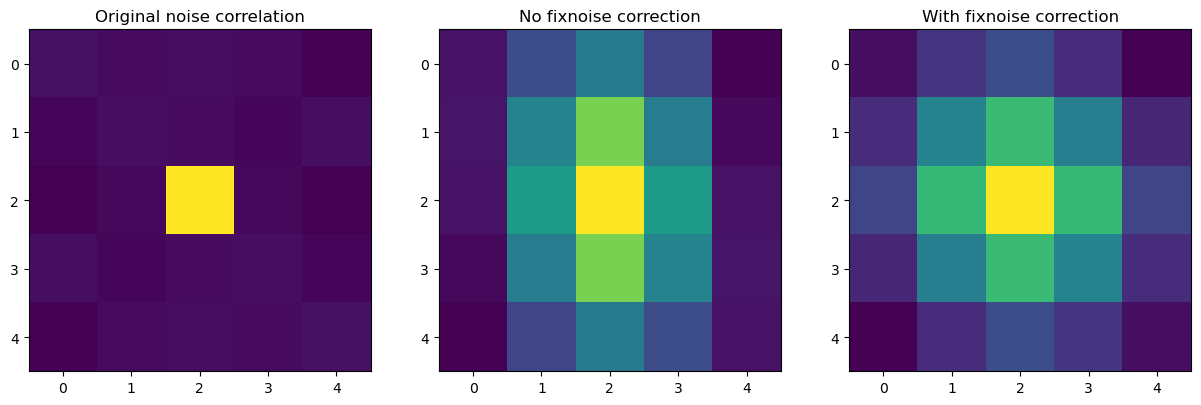

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(corr_orig)
axs[0].set_title("Original noise correlation")

axs[1].imshow(corr_no_fixnoise)
axs[1].set_title("No fixnoise correction")

axs[2].imshow(corr_fixnoise)
axs[2].set_title("With fixnoise correction")

## Response matrix and selection effects

The total shear response is: $R^{\rm{total}} = R^{\rm{shear}} + R^{\rm{selection}}$


#### The shear response

```math
R^{\rm{shear}}_{ij} = \langle \frac{e^{+,M^{+}}_{i} - e^{-,M^{-}}_{j}}{\Delta g_{j}} \rangle
```

Example:
```math
R^{\rm{shear}}_{11} = \langle \frac{e^{\rm{1p}, M^{\rm{1p}}}_{1} - e^{\rm{1m}, M^{\rm{1m}}}_{1}}{0.02} \rangle
```

Here $M^{X}$ is the selection mask for the sheared image $X$.

#### The selection response

```math
R^{\rm{selection}}_{ij} = \frac{\langle e^{0,M^{+}}_{i} \rangle - \langle e^{0,M^{-}}_{j} \rangle}{\Delta g_{j}}
```

Example:
```math
R^{\rm{selection}}_{11} = \frac{\langle e^{\rm{ns}, M^{\rm{1p}}}_{1} \rangle - \langle e^{\rm{ns}, M^{\rm{1m}} \rangle}_{1}}{0.02}
```

For the selection response the average is moved to each sheared ellipticity as: $\rm{lenght}(e^{\rm{ns}, M^{\rm{1p}}}_{1}) \neq \rm{lenght}(e^{\rm{ns}, M^{\rm{1m}}}_{1})$

#### The "Metadetection way" which do both at the same time

```math
R^{\rm{total}}_{ij} = \frac{\langle e^{+,M^{+}}_{i} \rangle - \langle e^{-,M^{-}}_{j} \rangle}{\Delta g_{j}}
```

Example:
```math
R^{\rm{total}}_{11} = \frac{\langle e^{\rm{1p}, M^{\rm{1p}}}_{1} \rangle - \langle e^{\rm{1m}, M^{\rm{1m}} \rangle}_{1}}{0.02}
```

For Metadetection we cannot compute the shear response as described above as: $\rm{lenght}(e^{\rm{1p}}_{1}) \neq \rm{lenght}(e^{\rm{1m}}_{1})$

## Measuring multiplicative bias

#### Simulation setup:

- Galaxy: *Exp*
- PSF: *Moffat*
- $\sigma_{\rm{noise}}$: $1e^{-5}$

#### Shape measurement:

Fitter: Adaptive moments



### Without Metacalibration

In [24]:
test_shear_meas(1000, simu_runner_no_mcal, meas_m_c_cancel)

  0%|          | 0/1000 [00:00<?, ?it/s]

time per: 0.0034095861911773682


  0%|          | 0/2 [00:00<?, ?it/s]



m [1e-3, 3sigma]: -802.3419273404653 +/- 0.3982609374776347
c [1e-5, 3sigma]: 0.1275478594838146 +/- 0.7017740643142522


### With Metacalibration

In [25]:
test_shear_meas(1000, simu_runner_mcal, meas_m_c_cancel_mcal)

  0%|          | 0/1000 [00:00<?, ?it/s]

time per: 0.0019885828495025634


  0%|          | 0/2 [00:00<?, ?it/s]



m [1e-3, 3sigma]: -0.2647252890080054 +/- 1.9262911803605842
c [1e-5, 3sigma]: 0.3467828093296841 +/- 4.334486661252663
